In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import os

In [21]:
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Text(0.5, 1.0, 'histogram of grey values')

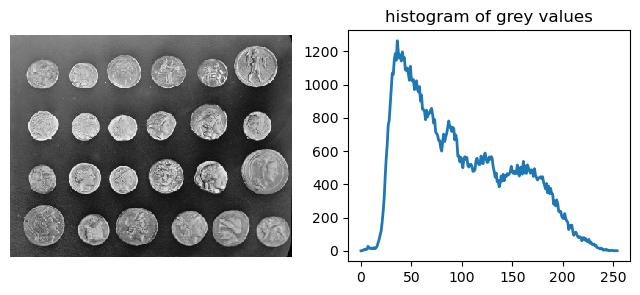

In [17]:
coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.plot(hist[1][:-1], hist[0], lw=2)
ax2.set_title('histogram of grey values')

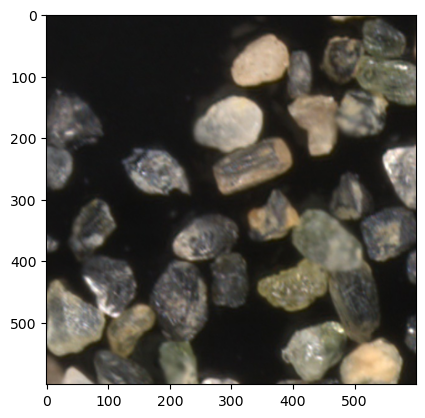

In [18]:
img = cv2.imread('data/Images/Echantillion1Mod2_301.png')
#Convert to rgb
imshow(img)

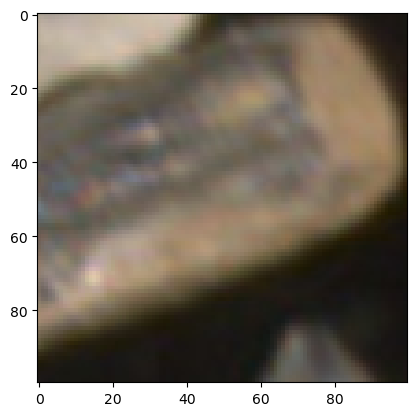

True

In [19]:
#Crop the image to a new one of 100x100
img_crop = img[200:300, 300:400]
imshow(img_crop)
#save it in data/saved_images
#Get the path of the execution
dir = r'C:\Users\julie\Docu'

cv2.imwrite('data/saved_images/cropped_image2.png', img_crop)

# Performing the algorithm - Region based segmentation

- Elevation map with Sobel
- Get markers (as extreme points of the histogram)
- Apply Watershed with these markers

In [47]:
from skimage.filters import sobel
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import cv2

In [49]:
def adjust_contrast(image, factor):
    """
    This function adjusts the contrast of an image.
    """
    image_c = np.zeros(image.shape, image.dtype)
    alpha = factor
    beta = 128 * (1 - alpha)
    cv2.addWeighted(image, alpha, np.zeros(image.shape, image.dtype), 0, beta, image_c)
    return image_c

def adjust_brightness(image, factor):
    """
    This function adjusts the brightness of an image.
    """
    image_b = np.zeros(image.shape, image.dtype)
    alpha = factor
    beta = 128 * (1 - alpha)
    cv2.addWeighted(image, alpha, np.zeros(image.shape, image.dtype), 0, beta, image_b)
    return image_b

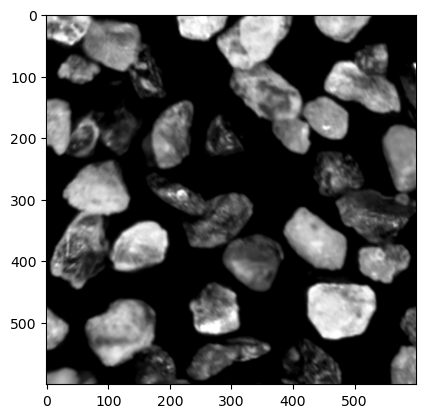

In [58]:
#Get the image
img = cv2.imread('data/Images/Echantillion1Mod2_304.png')
img = adjust_contrast(img, 1.5)
img = adjust_brightness(img, 1)
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(grey)

Text(0.5, 1.0, 'elevation_map')

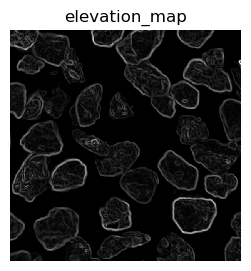

In [59]:
elevation_map = sobel(grey)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')

/var/folders/rb/qyycq0gd1vnbf173_z7d_33r0000gn/T/ipykernel_24317/1476598322.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral")


Text(0.5, 1.0, 'markers')

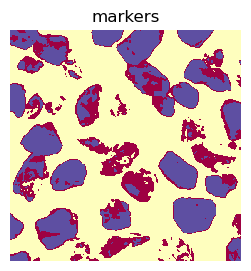

In [60]:
#Get the markers
markers = np.zeros_like(grey)
markers[grey < 50] = 1
markers[grey > 120] = 2

cmap = plt.cm.get_cmap("Spectral")

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=cmap, interpolation='nearest')
ax.axis('off')
ax.set_title('markers')


Text(0.5, 1.0, 'segmentation')

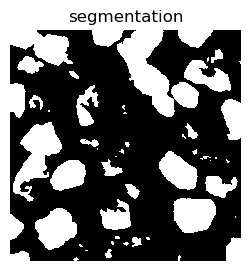

In [61]:
# Apply watershed
segmentation = watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('segmentation')

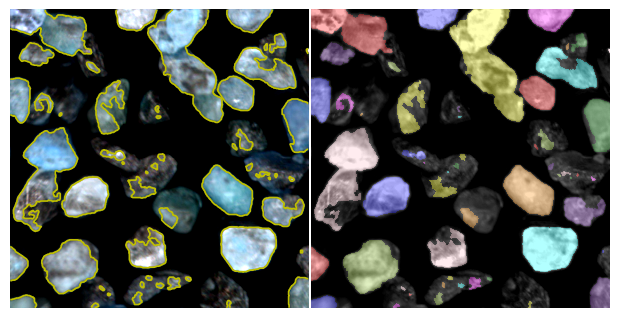

In [62]:
#Get the labels
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax1.set_adjustable('box')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box')
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.subplots_adjust(**margins)
